In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use("seaborn-whitegrid")
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## Loading data

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

y = train["Transported"]
#train_set.drop(["Transported"], axis=1, inplace = True)
print(f'train set: {train.shape[0]} rows, {train.shape[1]} columns')
print(f'test set: {test.shape[0]} rows, {test.shape[1]} columns')

train set: 8693 rows, 14 columns
test set: 4277 rows, 13 columns


### Feature descriptions:

* **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* **Destination** - The planet the passenger will be debarking to.
* **Age** - The age of the passenger.
* **VIP** - Whether the passenger has paid for special VIP service during the voyage.
* **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* **Name** - The first and last names of the passenger.
* **Transported** - Whether the passenger was transported to another dimension. This is the target.

# Exploratory data analysis:

In [3]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


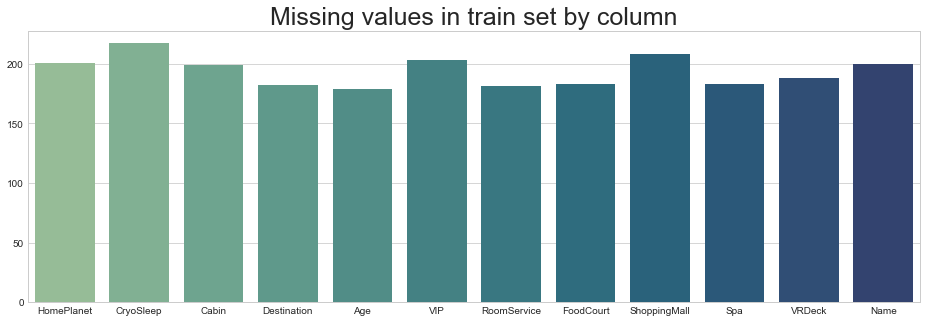

In [5]:
nan_cols = train.columns[train.isna().any()].tolist()
nan_amount = train[nan_cols].isna().sum()
plt.figure(figsize=(16,5))
sns.barplot(y=nan_amount, x=nan_cols, palette="crest")
plt.title("Missing values in train set by column", fontsize=25)
plt.show()

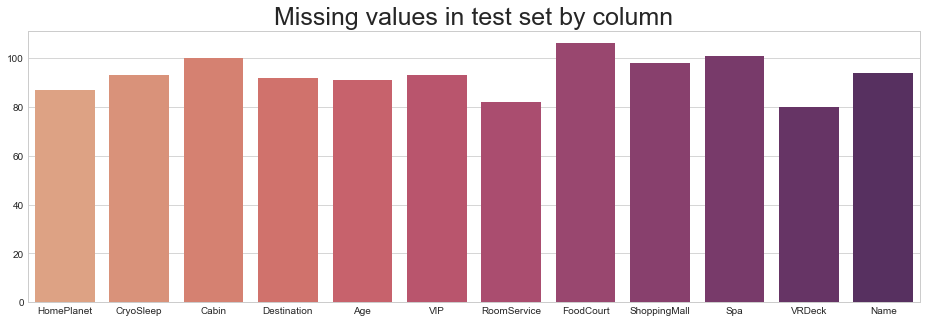

In [6]:
nan_cols = test.columns[test.isna().any()].tolist()
nan_amount = test[nan_cols].isna().sum()
plt.figure(figsize=(16,5))
sns.barplot(y=nan_amount, x=nan_cols, palette="flare")
plt.title("Missing values in test set by column", fontsize=25)
plt.show()

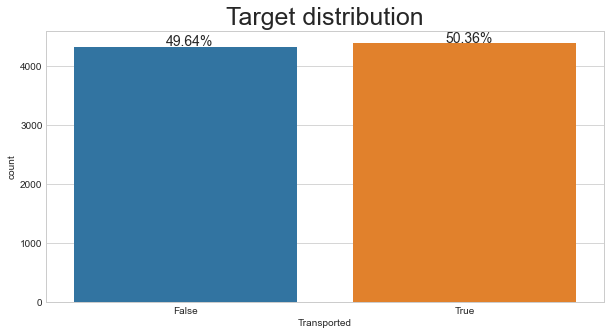

In [7]:
def add_percentage(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.07
        y = p.get_y() + p.get_height() + total*0.003
        ax.annotate(percentage, (x, y), size = 14)
        
plt.figure(figsize=(10,5))

ax = sns.countplot(y)
add_percentage(ax, y)
plt.title("Target distribution", fontsize=25)
plt.show()

In [8]:
num_feats = [cname for cname in train.columns if train[cname].dtype in ['int64', 'float64']]
obj_feats = [cname for cname in train.columns if cname not in num_feats and cname != 'Transported']
train[obj_feats].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines


In [9]:
train[obj_feats].nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

In [10]:
qual_feats = ['PassengerId', 'Cabin', 'Name']

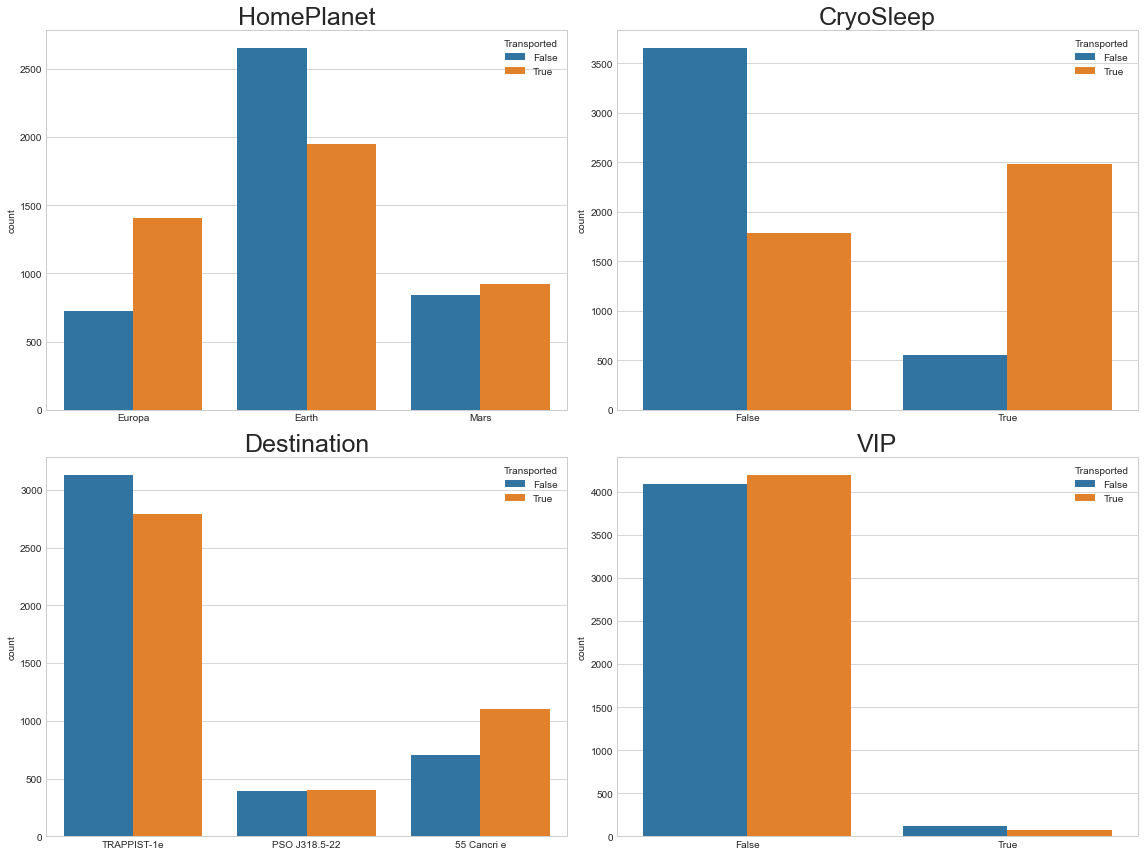

In [11]:
# Plot categorical features
cat_feats = [cname for cname in obj_feats if train[cname].nunique()<=3]
fig=plt.figure(figsize=(16,12))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(2,2,i+1)
    sns.countplot(data=train, x=var_name, hue='Transported')
    ax.set(xlabel='')
    ax.set_title(var_name, fontsize=25)
fig.tight_layout()
plt.show()

**It looks like CryoSleep is pretty important unlike VIP**

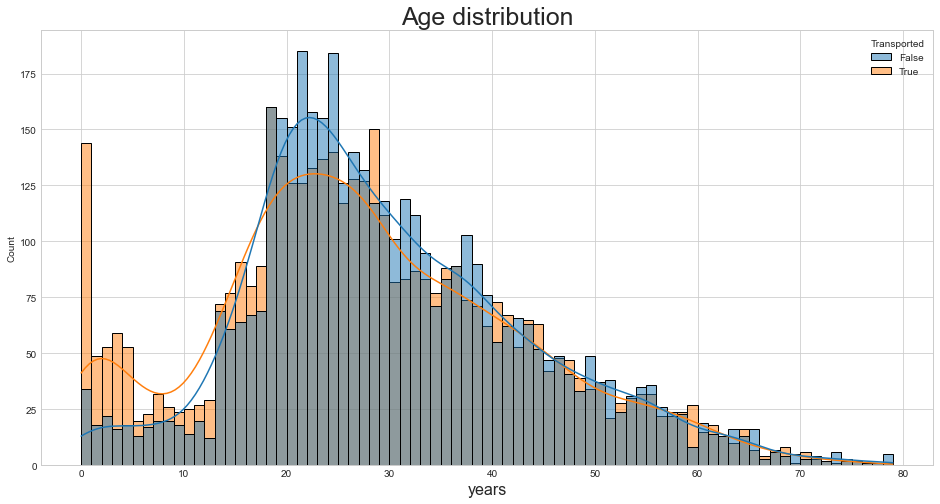

In [12]:
plt.figure(figsize=(16,8))

sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.title('Age distribution', fontsize=25)
plt.xlabel('years', fontsize=16)
plt.show()

**Younger passengers tend to be transported**

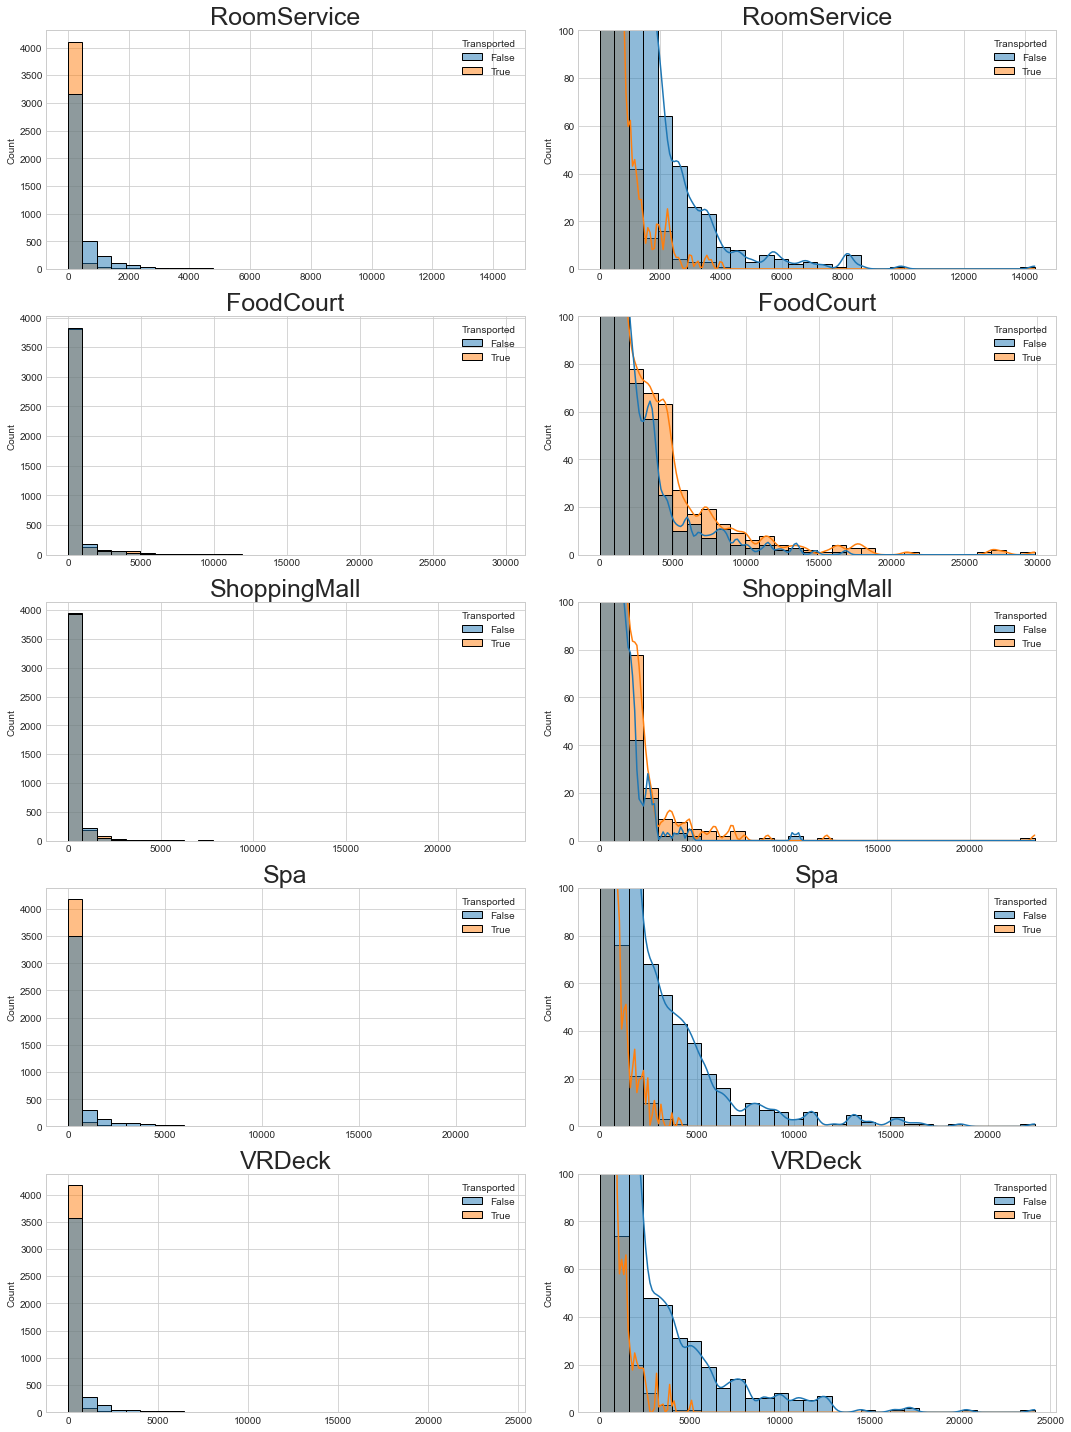

In [13]:
# expenditure features analysis
exp_feats = [cname for cname in num_feats if cname != 'Age']
fig = plt.figure(figsize=(15,20))
for i, var in enumerate(exp_feats):
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var, hue='Transported', bins=30, kde=False)
    ax.set(xlabel='')
    ax.set_title(var, fontsize=25)
    
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var, hue='Transported', bins=30, kde=True)
    ax.set_ylim([0, 100])
    ax.set(xlabel='')
    ax.set_title(var, fontsize=25)
    
fig.tight_layout()
plt.show()

**We can perceive FoodCourt and ShoppingMall as an essential expenditures and the rest as luxury expenditures**

# Feature engineering:
## Expenditure features

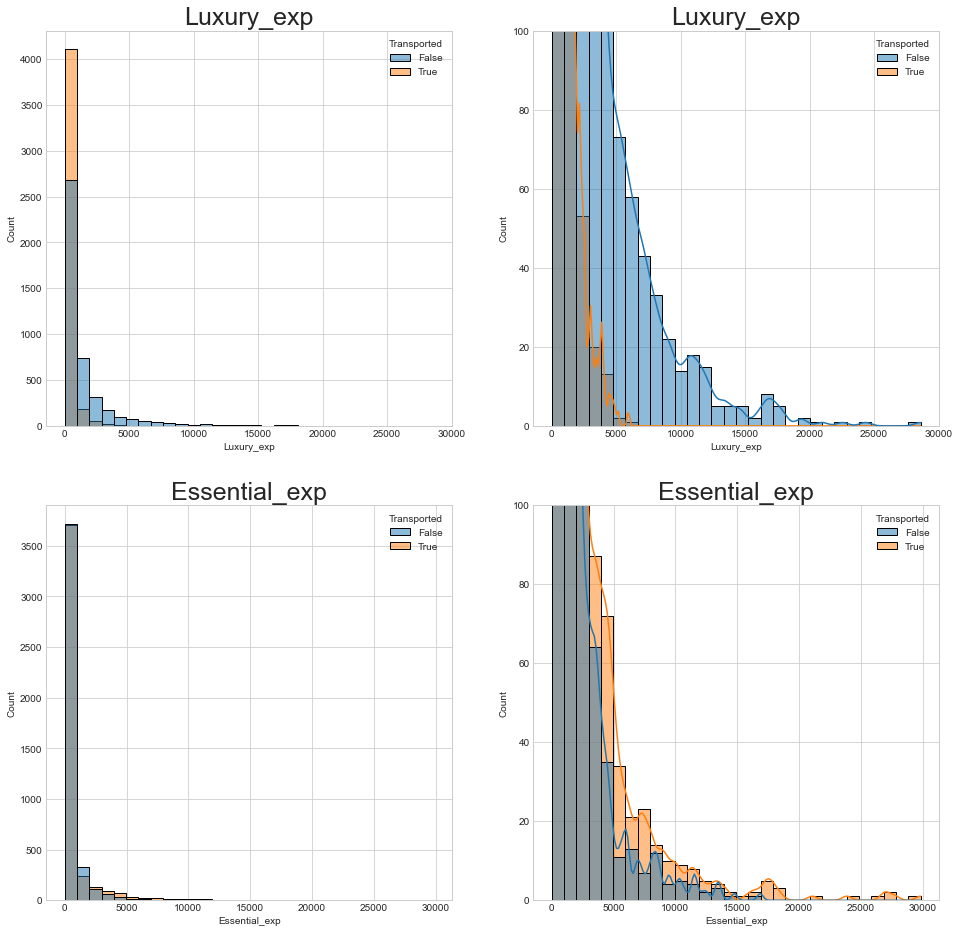

In [14]:
lux_feats = ['VRDeck', 'Spa', 'RoomService']
ess_feats = ['FoodCourt', 'ShoppingMall']


train['Luxury_exp'] = train[lux_feats].sum(axis=1)
train['Essential_exp'] = train[ess_feats].sum(axis=1)
train['Total_exp'] = train[exp_feats].sum(axis=1)

test['Luxury_exp'] = test[lux_feats].sum(axis=1)
test['Essential_exp'] = test[ess_feats].sum(axis=1)
test['Total_exp'] = test[exp_feats].sum(axis=1)

fig = plt.figure(figsize=(16,16))
for i, var in enumerate(['Luxury_exp', 'Essential_exp']):
    ax = fig.add_subplot(2,2,2*i+1)
    sns.histplot(data=train, x=var, hue='Transported', bins=30, kde=False)
    ax.set_title(var, fontsize=25)

    ax = fig.add_subplot(2,2,2*i+2)
    sns.histplot(data=train, x=var, hue='Transported', bins=30, kde=True)
    ax.set_title(var, fontsize=25)
    ax.set_ylim([0, 100])
plt.show()

**Luxury_exp chart shows that it can be useful to create binary feature of its spendings**

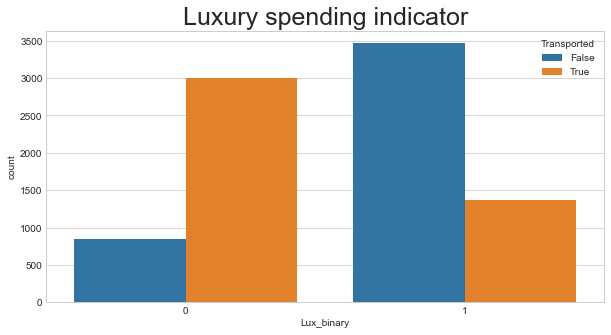

In [15]:
train['Total_binary'] = (train['Total_exp']!=0).astype(int)

test['Total_binary'] = (test['Total_exp']!=0).astype(int)


train['Lux_binary'] = (train['Luxury_exp']!=0).astype(int)

test['Lux_binary'] = (test['Luxury_exp']!=0).astype(int)

plt.figure(figsize=(10,5))
sns.countplot(data = train, x='Lux_binary', hue='Transported')
plt.title('Luxury spending indicator', fontsize=25)
plt.show()

## Age

In [16]:
train['Age_group']=np.nan
train.loc[train['Age']<=18,'Age_group']='Age_0-18'
train.loc[(train['Age']>18) & (train['Age']<=40),'Age_group']='Age_18-40'
train.loc[(train['Age']>40),'Age_group']='Age_40+'

test['Age_group']=np.nan
test.loc[test['Age']<=18,'Age_group']='Age_0-18'
test.loc[(test['Age']>18) & (test['Age']<=40),'Age_group']='Age_18-40'
test.loc[(test['Age']>40),'Age_group']='Age_40+'

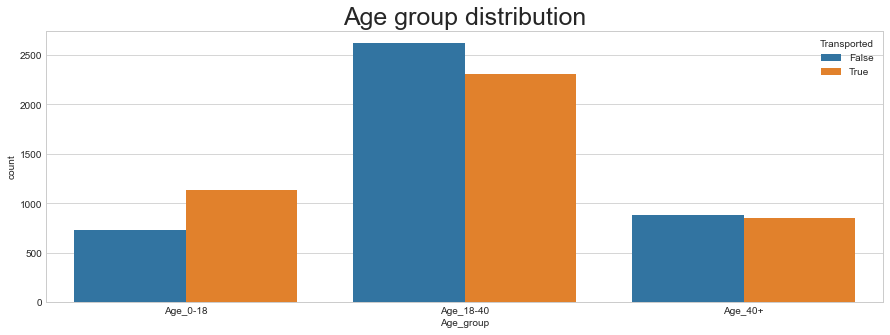

In [17]:
plt.figure(figsize=(15,5))
sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-18','Age_18-40','Age_40+'])
plt.title('Age group distribution', fontsize=25)
plt.show()

In [18]:
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

train['Group_size'] = train['Group'].map(lambda x: train['Group'].value_counts()[x])
test['Group_size'] = test['Group'].map(lambda x: test['Group'].value_counts()[x])

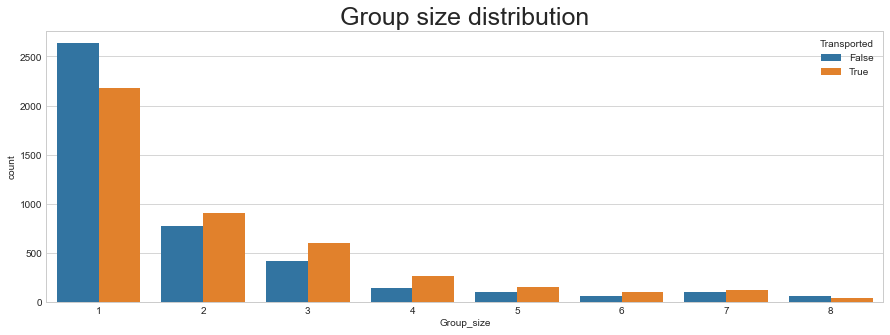

In [19]:
plt.figure(figsize=(15,5))
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size distribution', fontsize=25)
plt.show()

In [20]:
train['Solo'] = (train['Group_size']==1).astype(int)
test['Solo'] = (test['Group_size']==1).astype(int)

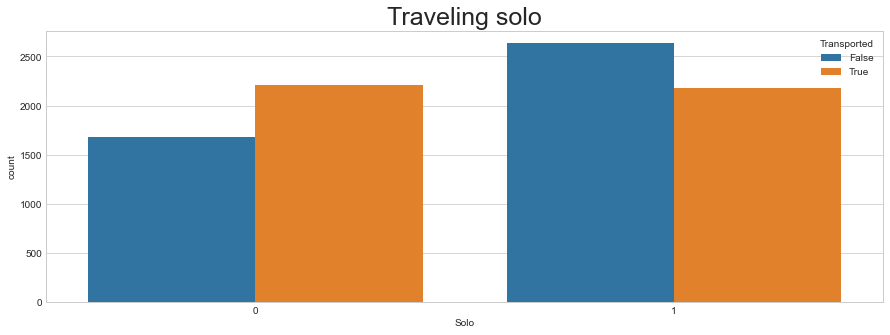

In [21]:
plt.figure(figsize=(15,5))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Traveling solo', fontsize=25)
plt.show()

## Cabin

In [22]:
Cabin_df = train["Cabin"].str.split("/", expand = True)
Cabin_df.columns = ['Deck', 'Number', 'Side']
train = pd.concat([train, Cabin_df], axis=1)
train.Number = train.Number.astype('float64')

Cabin_df = test["Cabin"].str.split("/", expand = True)
Cabin_df.columns = ['Deck', 'Number', 'Side']
test = pd.concat([test, Cabin_df], axis=1)
test.Number = test.Number.astype('float64')


train.drop(['Cabin'], axis=1, inplace = True)
test.drop(['Cabin'], axis=1, inplace = True)

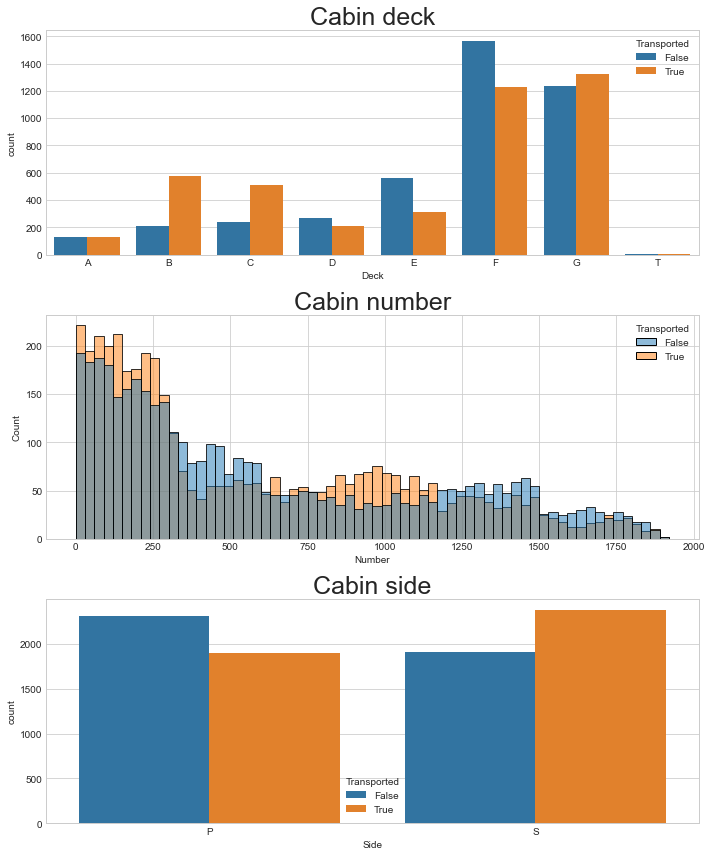

In [23]:
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck', fontsize=25)

plt.subplot(3,1,2)
sns.histplot(data=train, x='Number', hue='Transported',binwidth=30)
plt.title('Cabin number', fontsize=25)
#plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Side', hue='Transported')
plt.title('Cabin side', fontsize=25)
fig.tight_layout()

**We can see that numbers of Cabin are grouped to regions, so it makes sense to create categorical feature from it**

In [24]:
train['Cabin_region'] = np.nan
train.loc[train['Number']<=300,'Cabin_region']='Reg_1'
train.loc[(train['Number']>300) & (train['Number']<=700),'Cabin_region']='Reg_2'
train.loc[(train['Number']>700) & (train['Number']<=1150),'Cabin_region']='Reg_3'
train.loc[(train['Number']>1150),'Cabin_region']='Reg_4'


test['Cabin_region'] = np.nan
test.loc[test['Number']<=300,'Cabin_region']='Reg_1'
test.loc[(test['Number']>300) & (test['Number']<=700),'Cabin_region']='Reg_2'
test.loc[(test['Number']>700) & (test['Number']<=1150),'Cabin_region']='Reg_3'
test.loc[(test['Number']>1150),'Cabin_region']='Reg_4'

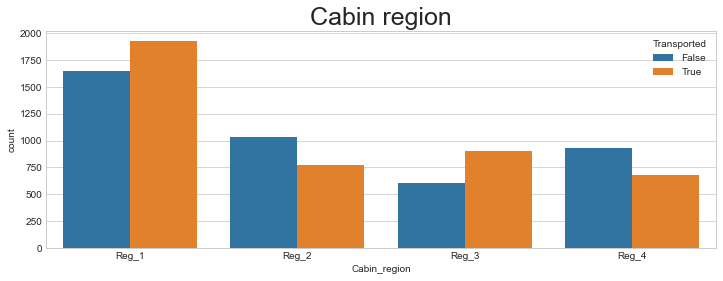

In [25]:
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Cabin_region', hue='Transported')
plt.title('Cabin region', fontsize=25)
fig.tight_layout()

## Name

In [26]:
train['Surname'] = train['Name'].str.split().str[-1]
test['Surname'] = test['Name'].str.split().str[-1]

train['Surname'].fillna('Unknown', inplace=True)
test['Surname'].fillna('Unknown', inplace=True)

train['Family_size'] = train['Surname'].map(lambda x: train['Surname'].value_counts()[x])
test['Family_size'] = test['Surname'].map(lambda x: test['Surname'].value_counts()[x])

train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

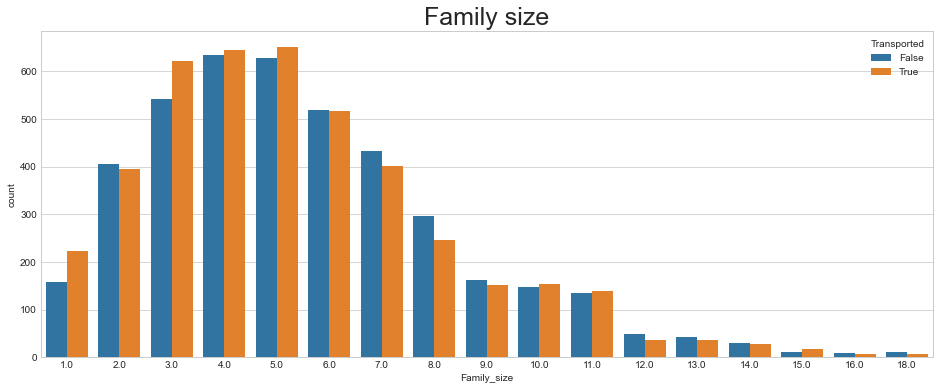

In [27]:
plt.figure(figsize=(16,6))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size', fontsize=25)
plt.show()

# Dealing with missing values:
**Our goal is to get as much information from joint distribution of features**
## Home planet

In [28]:
X = train.drop('Transported', axis=1).copy()

data=pd.concat([X, test], axis=0).reset_index(drop=True)

In [29]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet']).size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


In [30]:
print(f'Nubmer of groups with unique home planet: {(GHP_gb>0).sum(axis=1).sum()}')
print(f'Total number of groups: {len(GHP_gb)}')

Nubmer of groups with unique home planet: 9124
Total number of groups: 9124


In [31]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('HomePlanet missing values before:',HP_bef)
print('HomePlanet missing values after:',data['HomePlanet'].isna().sum())

HomePlanet missing values before: 288
HomePlanet missing values after: 157


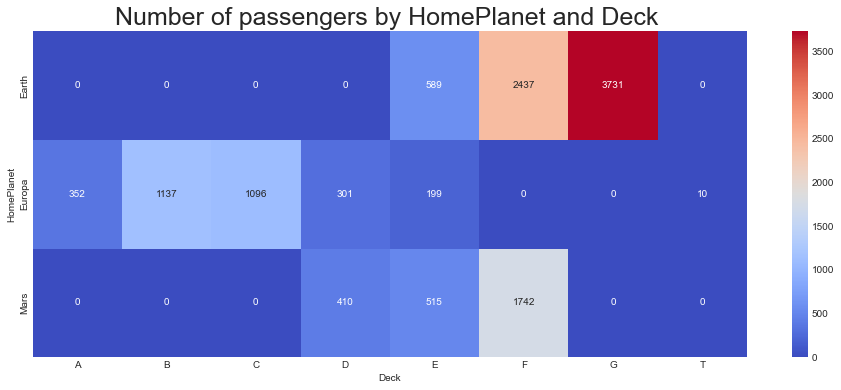

In [32]:
# Joint distribution of CabinDeck and HomePlanet
DHP_gb=data.groupby(['Deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(16,6))
sns.heatmap(DHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.title('Number of passengers by HomePlanet and Deck ', fontsize=25)
plt.show()

* Passengers on decks A, B, C or T came from Europa.
* Passengers on deck G came from Earth.

In [33]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Deck']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


In [34]:
# Joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet']).size().unstack().fillna(0)

print(f'Nubmer of surenames with unique home planet: {(SHP_gb>0).sum(axis=1).sum()}')
print(f'Total number of surenames: {len(SHP_gb)}')

Nubmer of surenames with unique home planet: 2402
Total number of surenames: 2402


In [35]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


In [36]:
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


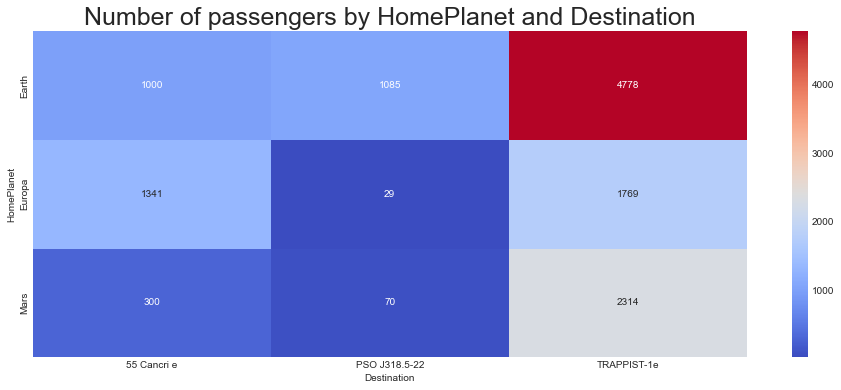

In [37]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination']).size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(16,6))
sns.heatmap(HPD_gb, annot=True, fmt='g', cmap='coolwarm')
plt.title('Number of passengers by HomePlanet and Destination', fontsize=25)
plt.show()

**Most people heading towards TRAPPIST-1e came from Earth but from previous chart we know that nobody on deck D came from Earth so we need to keep that in mind**

In [38]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('HomePlanet missing values before:',HP_bef)
print('HomePlanet missing values after:',data['HomePlanet'].isna().sum())

HomePlanet missing values before: 10
HomePlanet missing values after: 0


## Destination

**Almost 70% of passengers are heading towards TRAPPIST-1e so we can just impute this value**

In [39]:
# Missing values before
D_bef=data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('Destination missing values before:',D_bef)
print('Destination missing values after:',data['Destination'].isna().sum())

Destination missing values before: 274
Destination missing values after: 0


## Surname

Text(0.5, 1.0, 'Number of unique surnames by group')

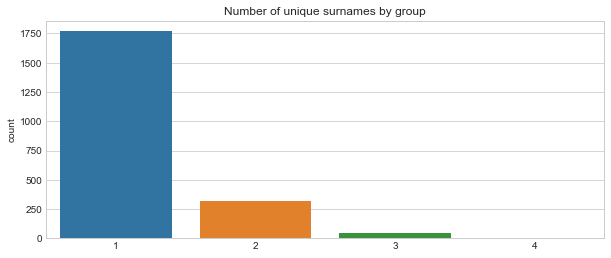

In [40]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((GSN_gb>0).sum(axis=1))
plt.title('Number of unique surnames by group')

In [41]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('Surname missing values before:',SN_bef)
print('Surname missing values after:',data['Surname'].isna().sum())

Surname missing values before: 294
Surname missing values after: 155


**We don't have to fill all of these missing values, because we will frop Surname feature anyway**

In [42]:
# Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# Say unknown surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

## Cabin side

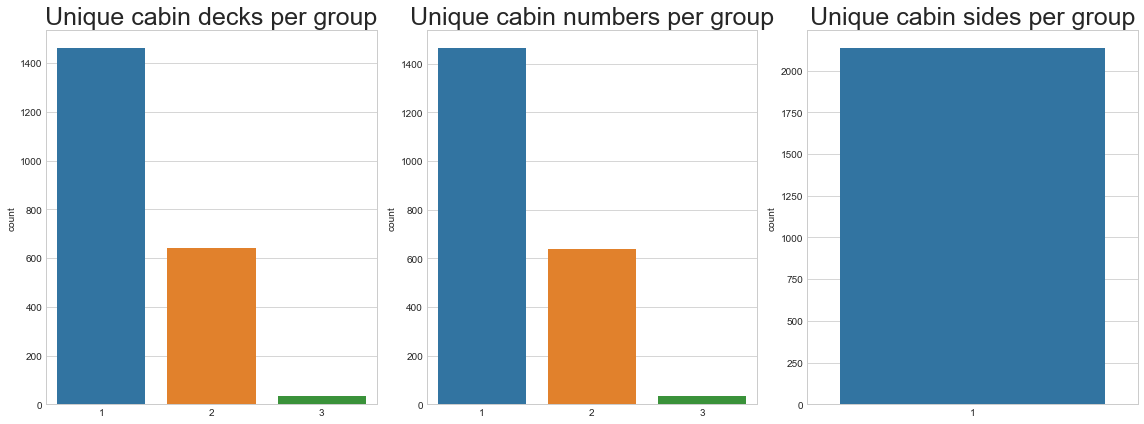

In [43]:
# Joint distribution of Group and Cabin features
GCD_gb=data[data['Group_size']>1].groupby(['Group','Deck']).size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Number']).size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Side']).size().unstack().fillna(0)

# Countplots
fig=plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
sns.countplot((GCD_gb>0).sum(axis=1))
plt.title('Unique cabin decks per group',fontsize=25)

plt.subplot(1,3,2)
sns.countplot((GCN_gb>0).sum(axis=1))
plt.title('Unique cabin numbers per group',fontsize=25)

plt.subplot(1,3,3)
sns.countplot((GCS_gb>0).sum(axis=1))
plt.title('Unique cabin sides per group',fontsize=25)
fig.tight_layout()

**Everyone in the same group is also on the same cabin side**

In [44]:
# Missing values before
CS_bef=data['Side'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin side
GCS_index=data[data['Side'].isna()][(data[data['Side'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index,'Side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('Cabin_side missing values before:',CS_bef)
print('Cabin_side missing values after:',data['Side'].isna().sum())

Cabin_side missing values before: 299
Cabin_side missing values after: 162


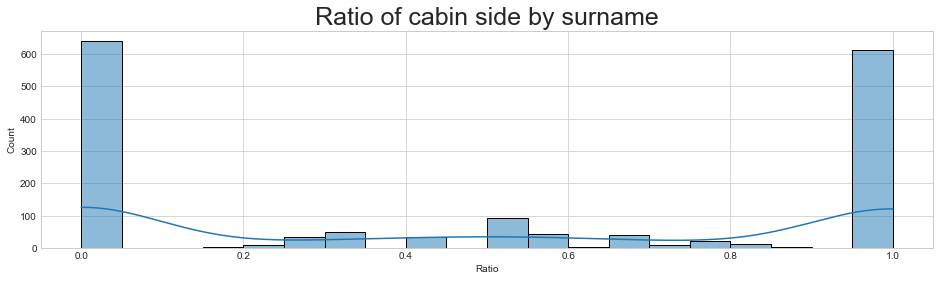

In [45]:
# Joint distribution of Surname and Cabin side
SCS_gb=data[data['Group_size']>1].groupby(['Surname','Side'])['Side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(16,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname', fontsize=25)
plt.show()

In [46]:
# Print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# Another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 76.7 %


Side,P,S,Ratio
Surname,,,
Acobson,0.0,3.0,0.0
Acobsond,3.0,0.0,1.0
Adavisons,6.0,0.0,1.0
Admingried,0.0,4.0,0.0
Aginge,3.0,0.0,1.0


**77% of families are entirely on the same side**

In [47]:
# Missing values before
CS_bef=data['Side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

# Passengers with missing Cabin side and in a family with known Cabin side
SCS_index=data[data['Side'].isna()][(data[data['Side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding missing values
data.loc[SCS_index,'Side']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Drop surname (we don't need it anymore)
data.drop('Surname', axis=1, inplace=True)

# Print number of missing values left
print('Cabin_side missing values before:',CS_bef)
print('Cabin_side missing values after:',data['Side'].isna().sum())

Cabin_side missing values before: 162
Cabin_side missing values after: 66


In [48]:
# Value counts
data['Side'].value_counts()

S    6504
P    6400
Name: Side, dtype: int64

**Filling the rest with bfill method**

In [49]:
# Missing values before
CS_bef=data['Side'].isna().sum()

data['Side'] = data['Side'].fillna(method='bfill', axis=0)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Side'].isna().sum())

#Cabin_side missing values before: 66
#Cabin_side missing values after: 0


## Deck

**We remember that groups tend to be on the same cabin deck**

In [50]:
# Missing values before
CD_bef=data['Deck'].isna().sum()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index=data[data['Deck'].isna()][(data[data['Deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding missing values
data.loc[GCD_index,'Deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


In [51]:
# Joint distribution
data.groupby(['HomePlanet','Destination','Solo','Deck']).size().unstack().fillna(0)

Deck                               A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Deck                                G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

In [52]:
# Missing values before
CD_bef=data['Deck'].isna().sum()

# Fill missing values using the mode
na_rows_CD=data.loc[data['Deck'].isna(),'Deck'].index
data.loc[data['Deck'].isna(),'Deck']=data.groupby(['HomePlanet','Destination','Solo'])['Deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Print number of missing values left
print('Cabin_deck missing values before:',CD_bef)
print('Cabin_deck missing values after:',data['Deck'].isna().sum())

Cabin_deck missing values before: 162
Cabin_deck missing values after: 0


## Number

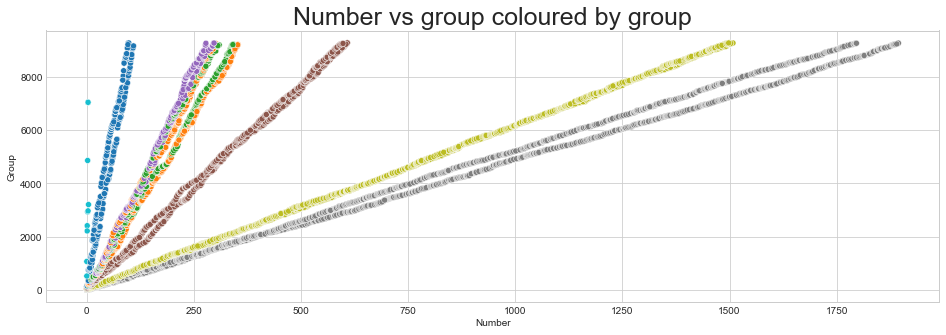

In [53]:
# Scatterplot
plt.figure(figsize=(16,5))
sns.scatterplot(x=data['Number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Number'].isna(),'Deck']), cmap='tab10')
plt.title('Number vs group coloured by group', fontsize=25)
plt.show()

**We can see a linear relationship between those two features, we can use linear regression to get an approximate cabin number**

In [54]:
# Missing values before
CN_bef=data['Number'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN=data.loc[~(data['Number'].isna()) & (data['Deck']==deck),'Group']
    y_CN=data.loc[~(data['Number'].isna()) & (data['Deck']==deck),'Number']
    X_test_CN=data.loc[(data['Number'].isna()) & (data['Deck']==deck),'Group']

    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    # Fill missing values with predictions
    data.loc[(data['Number'].isna()) & (data['Deck']==deck),'Number']=preds_CN.astype(int)

# Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Number'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


In [55]:
# updating regions
data.loc[data['Number']<=300,'Cabin_region']='Reg_1'
data.loc[(data['Number']>300) & (data['Number']<=700),'Cabin_region']='Reg_2'
data.loc[(data['Number']>700) & (data['Number']<=1150),'Cabin_region']='Reg_3'
data.loc[(data['Number']>1150),'Cabin_region']='Reg_4'

## VIP

In [56]:
# Missing values before
V_bef=data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(),'VIP']=False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


## Age

In [57]:
# Joint distribution
data.groupby(['HomePlanet','Lux_binary','Solo','Deck'])['Age'].median().unstack().fillna(0)

Deck                           A     B     C     D     E     F     G     T
HomePlanet Lux_binary Solo                                                
Earth      0          0      0.0   0.0   0.0   0.0   9.5  20.0   9.0   0.0
                      1      0.0   0.0   0.0   0.0  24.0  23.0  23.0   0.0
           1          0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                      1      0.0   0.0   0.0   0.0  25.0  24.0  27.0   0.0
Europa     0          0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                      1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
           1          0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                      1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
Mars       0          0      0.0   0.0   0.0  29.0  26.0  18.0   0.0   0.0
                      1      0.0   0.0   0.0  36.5  30.0  29.0   0.0   0.0
           1          0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                      1      0.0   0.0   0.0  31.0  28.0  31.0   0.0   0.0

In [58]:
# Missing values before
A_bef=data[exp_feats].isna().sum().sum()

# Fill missing values using the median
na_rows_A=data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','Lux_binary','Solo','Deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

# Print number of missing values left
print('#Age missing values before:',A_bef)
print('#Age missing values after:',data['Age'].isna().sum())

#Age missing values before: 1410
#Age missing values after: 0


In [59]:
# updating Age gruops
data.loc[data['Age']<=18,'Age_group']='Age_0-18'
data.loc[(data['Age']>18) & (data['Age']<=40),'Age_group']='Age_18-40'
data.loc[(data['Age']>40),'Age_group']='Age_40+'

## CryoSleep

**The best way to predict if a passenger is in CryoSleep or not is to see if they spent anything**

In [60]:
# Joint distribution
data.groupby(['Total_binary','CryoSleep']).size().unstack().fillna(0)

CryoSleep,False,True
Total_binary,,
0,740.0,4581.0
1,7339.0,0.0


In [61]:
# Missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# Fill missing values using the mode
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['Total_binary'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Print number of missing values left
print('CryoSleep missing values before:',CSL_bef)
print('CryoSleep missing values after:',data['CryoSleep'].isna().sum())

CryoSleep missing values before: 310
CryoSleep missing values after: 0


## Expenditure

In [62]:
print('Maximum expenditure of passengers in CryoSleep:',data.loc[data['CryoSleep']==True,exp_feats].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [63]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# CryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0 

# Print number of missing values left
print('Expenditure missing values before:',E_bef)
print('Expenditure missing values after:',data[exp_feats].isna().sum().sum())

Expenditure missing values before: 1410
Expenditure missing values after: 866


In [64]:
# Joint distribution
data.groupby(['HomePlanet','Solo','Age_group'])['Total_exp'].mean().unstack().fillna(0)

Age_group           Age_0-18    Age_18-40      Age_40+
HomePlanet Solo                                       
Earth      0      195.974382   786.026612   743.175824
           1      635.090090   787.657383   821.030941
Europa     0     1024.392453  3588.887072  3588.569149
           1     1887.958333  3676.426367  3894.161383
Mars       0      499.502513  1204.854137  1189.298450
           1     1319.083969  1087.766702  1107.971061

In [65]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# Fill remaining missing values using the median
for col in exp_feats:
    na_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]
    
# Print number of missing values left
print('Expenditure missing values before:',E_bef)
print('Expenditure missing values after:',data[exp_feats].isna().sum().sum())

Expenditure missing values before: 866
Expenditure missing values after: 0


In [66]:
# Update expenditure features
data['Total_exp']=data[exp_feats].sum(axis=1)
data['Luxury_exp']=data[lux_feats].sum(axis=1)
data['Essen tial_exp']=data[ess_feats].sum(axis=1)
data['Lux_binary']=(data['Luxury_exp']==0).astype(int)
data['Total_binary']=(data['Total_exp']==0).astype(int)

In [67]:
data.isna().sum()

PassengerId         0
HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              294
Luxury_exp          0
Essential_exp       0
Total_exp           0
Total_binary        0
Lux_binary          0
Age_group           0
Group               0
Group_size          0
Solo                0
Deck                0
Number              0
Side                0
Cabin_region        0
Family_size         0
Essen tial_exp      0
dtype: int64

In [68]:
# Train and test
X=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

In [69]:
X.drop(['PassengerId', 'Group', 'Name', 'Number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Name', 'Number'], axis=1, inplace=True)

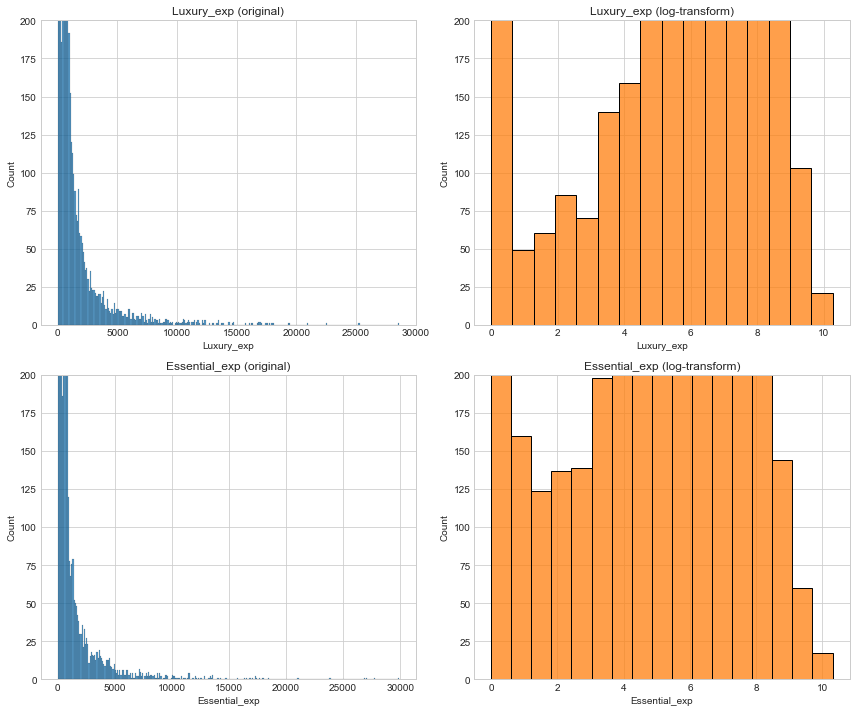

In [70]:
# Plot log transform results
fig=plt.figure(figsize=(12,10))
for i, col in enumerate(['Luxury_exp', 'Essential_exp']):
    plt.subplot(2,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(2,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

**We can apply log transformation to all expenditure features in order to make them less skewed**

In [71]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck', 'Total_exp','Luxury_exp', 'Essential_exp']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

In [72]:
X.dtypes

HomePlanet         object
CryoSleep          object
Destination        object
Age               float64
VIP                object
RoomService       float64
FoodCourt         float64
ShoppingMall      float64
Spa               float64
VRDeck            float64
Luxury_exp        float64
Essential_exp     float64
Total_exp         float64
Total_binary        int32
Lux_binary          int32
Age_group          object
Group_size          int64
Solo                int32
Deck               object
Side               object
Cabin_region       object
Family_size         int64
Essen tial_exp    float64
dtype: object

In [73]:
X.nunique()

HomePlanet           3
CryoSleep            2
Destination          3
Age                 83
VIP                  2
RoomService       1289
FoodCourt         1522
ShoppingMall      1129
Spa               1343
VRDeck            1322
Luxury_exp        2560
Essential_exp     1966
Total_exp         2638
Total_binary         2
Lux_binary           2
Age_group            3
Group_size           8
Solo                 2
Deck                 8
Side                 2
Cabin_region         4
Family_size         20
Essen tial_exp    2086
dtype: int64

**Creating dummy columns from categorical features**

In [74]:
#dum_cols = ['HomePlanet', 'Destination', 'Deck', 'Cabin_region']
dum_cols = [col for col in X.columns if 2<X[col].nunique()<=20]

dum_test_df = pd.get_dummies(X_test[dum_cols])
X_test = pd.concat([X_test, dum_test_df], axis=1)
X_test.drop(dum_cols, axis=1, inplace = True)
X_test.columns

dum_train_df = pd.get_dummies(X[dum_cols])
X = pd.concat([X, dum_train_df], axis=1)
X.drop(dum_cols, axis=1, inplace = True)
X.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Luxury_exp', 'Essential_exp', 'Total_exp',
       'Total_binary', 'Lux_binary', 'Solo', 'Side', 'Essen tial_exp',
       'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'Age_group_Age_0-18', 'Age_group_Age_18-40',
       'Age_group_Age_40+', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Cabin_region_Reg_1',
       'Cabin_region_Reg_2', 'Cabin_region_Reg_3', 'Cabin_region_Reg_4'],
      dtype='object')

In [75]:
X.dtypes

CryoSleep                     object
Age                          float64
VIP                           object
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Luxury_exp                   float64
Essential_exp                float64
Total_exp                    float64
Total_binary                   int32
Lux_binary                     int32
Solo                           int32
Side                          object
Essen tial_exp               float64
HomePlanet_Earth               uint8
HomePlanet_Europa              uint8
HomePlanet_Mars                uint8
Destination_55 Cancri e        uint8
Destination_PSO J318.5-22      uint8
Destination_TRAPPIST-1e        uint8
Age_group_Age_0-18             uint8
Age_group_Age_18-40            uint8
Age_group_Age_40+              uint8
Deck_A                         uint8
Deck_B                         uint8
D

In [76]:
X['Side'].replace({'P':0, 'S':1}, inplace=True)
X_test['Side'].replace({'P':0, 'S':1}, inplace=True)
cols_dtype_to_change = [cols for cols in X.columns if (X[cols].dtype in ['uint8', 'int32', 'object'])]
X[cols_dtype_to_change] = X[cols_dtype_to_change].astype('int64')
X_test[cols_dtype_to_change] = X_test[cols_dtype_to_change].astype('int64')
X.dtypes

CryoSleep                      int64
Age                          float64
VIP                            int64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Luxury_exp                   float64
Essential_exp                float64
Total_exp                    float64
Total_binary                   int64
Lux_binary                     int64
Solo                           int64
Side                           int64
Essen tial_exp               float64
HomePlanet_Earth               int64
HomePlanet_Europa              int64
HomePlanet_Mars                int64
Destination_55 Cancri e        int64
Destination_PSO J318.5-22      int64
Destination_TRAPPIST-1e        int64
Age_group_Age_0-18             int64
Age_group_Age_18-40            int64
Age_group_Age_40+              int64
Deck_A                         int64
Deck_B                         int64
D

In [77]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype == 'float64']
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
ct = ColumnTransformer(
    transformers=[('num', numerical_transformer, numerical_cols)],remainder='passthrough')
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

In [78]:
y = y.astype('int64')

In [79]:
# Train-validation split
train_X, valid_X, train_y, valid_y = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

**Setting grids for gradient boosting models**

In [81]:
# Classifiers
classifiers = {
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
}

# Grids for grid search


boosted_grid = {'n_estimators': [50, 80, 100, 120, 150, 200],
        'max_depth': [2, 3, 4, 5, 6],
        'learning_rate': [0.05, 0.1, 0.15],
        'reg_lambda': [0.1, 0.2],
        'colsample_bytree': [1, 0.8],
        'subsample': [1, 0.8],
        "min_data_in_leaf": [10],
        "min_sum_hessian_in_leaf": [1e-01],
               }
old_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}


xgb_grid = {'n_estimators': [100, 125, 150, 175, 200],
        'max_depth': [2, 3, 4, 6, 8, 10],
        'learning_rate': [0.05, 0.1, 0.15],
        'min_child_weight': [1, 2],
        'subsample': [0.9, 1],
        'reg_lambda': [0.8, 0.9, 1],
           }

# Dictionary of all grids
grid = {

    "XGBoost" : xgb_grid,
    "LGBM" : xgb_grid,
    "CatBoost" : old_grid,
}

In [82]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None if key == 'CatBoost' else 10)

    # Train and score
    clf.fit(train_X, train_y)
    valid_scores.iloc[i,1]=clf.score(valid_X, valid_y)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Model: XGBoost
Training time (mins): 110.47

Model: LGBM
Training time (mins): 28.63

Model: CatBoost
Training time (mins): 10.52



In [83]:
valid_scores

,Classifer,Validation accuracy,Training time
0,XGBoost,0.807361,110.47
1,LGBM,0.799885,28.63
2,CatBoost,0.807361,10.52


In [84]:
clf_best_params

{'XGBoost': {'learning_rate': 0.1,
  'max_depth': 4,
  'min_child_weight': 2,
  'n_estimators': 150,
  'reg_lambda': 0.8,
  'subsample': 0.9},
 'LGBM': {'learning_rate': 0.05,
  'max_depth': 6,
  'min_child_weight': 2,
  'n_estimators': 125,
  'reg_lambda': 0.8,
  'subsample': 0.9},
 'CatBoost': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}}

In [85]:
# Classifiers
best_classifiers = {
    "XGBoost" : XGBClassifier(**clf_best_params["XGBoost"], random_state=42),
    "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=False, random_state=42),
    #"LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=42),
}

In [86]:
preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    clf = classifier
    clf.fit(X, y)

    # Make predictions and measure accuracy
    preds += clf.predict_proba(X_test)[:,1]
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/len(best_classifiers)

[14:24:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model: XGBoost
Training time (mins): 0.01

Model: CatBoost
Training time (mins): 0.01



Text(0.5, 0, 'Probability')

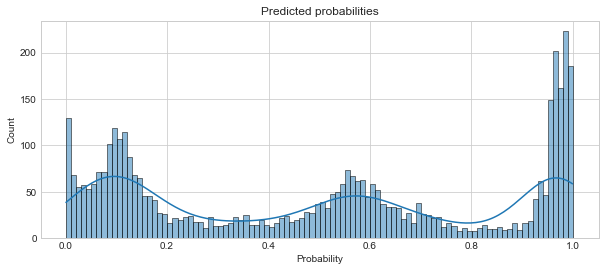

In [87]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

In [88]:
# Proportion (in test set) we get from rounding
print(np.round(100*np.round(preds).sum()/len(preds),2))

53.19


Optimal threshold: 0.514


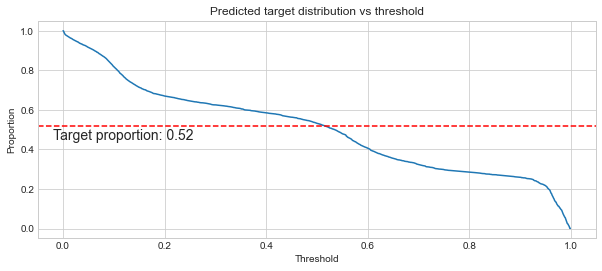

In [136]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.52      
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    # Find optimal threshold (the one that leads to the proportion being closest to target_prop)
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)

In [137]:
# Classify test set using optimal threshold
preds_tuned=(preds>=T_opt).astype(int)

Text(0.5, 1.0, 'Prediction distribution')

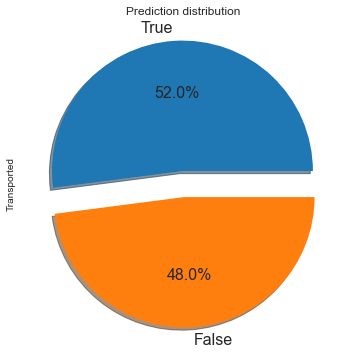

In [138]:
sub = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Transported": preds_tuned.astype(bool),
})

# Prediction distribution
plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

In [135]:
sub.to_csv('xgbcat52', index=False)